TP 3 : Plongements lexicaux et réécriture de textes
====

1 - Introduction 
------

Dans ce TP, nous aborderons les plongements lexicaux à travers la bibliothèque Gensim et nous verrons comment réécrire des textes dans le cadre du projet d'écriture créative OULIPO (https://fr.wikipedia.org/wiki/Oulipo).

N'hésitez pas à regarder régulièrement la documentation des librairies, des exemples d\'utilisation accompagnent généralement l\'explication de chaque fonction.

- Gensim : https://radimrehurek.com/gensim/apiref.html
- Scikit-learn : https://scikit-learn.org/stable/


Installation des librairies si nécessaire.

In [1]:
#!pip install --upgrade gensim
#!pip install --upgrade scikit-learn

Import des librairies.

In [2]:
import gensim
from gensim import corpora
import gensim.downloader as api
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from nltk.corpus import stopwords
import nltk
from pprint import pprint

Charger un modèle du langage. Attention les modèles peuvent être assez lourds et leur chargement peut prendre un certain temps. Tous les modèles sont accessibles [ICI](https://github.com/RaRe-Technologies/gensim-data). 

In [3]:
# pour GloVe
wv = api.load('glove-wiki-gigaword-300')

# pour FastText
# wv = api.load('fasttext-wiki-news-subwords-300')

# pour ConceptNet Numberbatch
# wv = api.load('conceptnet-numberbatch-17-06-300')

# pour Word2vec
# wv = api.load('word2vec-google-news-300')

2 - Analyser les plongements lexicaux 
------

Identifier la taille du plongement. Le nombre de lignes correspond au nombre de mots répertoriés dans le plogement et le nombre de colonnnes correspond au nombre de dimensions latentes de la représentation vectorielle.

In [4]:
wv.vectors.shape

(400000, 300)

Accéder au vecteur d'un mot donné.

In [5]:
wv['cat'].shape

(300,)

Calculer la similarité cosinus entre deux mots à partir des représentations vectorielles.

In [6]:
from numpy.linalg import norm
def cosine_similarity(A, B):
    return np.dot(A,B)/(norm(A)*norm(B))
cosine_similarity(wv['football'], wv['soccer'])

0.7682592

[Q1] Définir la distance euclidienne entre deux mots à partir des représentations vectorielles.

In [7]:

vecteur_A = wv['cat']
vecteur_B = wv["dog"]


distance_euclidienne = sum((vecteur_A - vecteur_B)**2)**0.5
print(f"Distance euclidienne entre cat et dog : {distance_euclidienne}")


Distance euclidienne entre cat et dog : 5.195904651147451


[Q2] Trouver la méthode qui implémente le cosinus dans Gensim, et montrer les résultats pour les paires de mots suivantes: (football, soccer), (football, elephant), (good, bad), (black, white), (yesterday,tomorrow). Quelles sont vos remarques?

In [8]:

# Paires de mots à comparer
paires_de_mots = [('football', 'soccer'), ('football', 'elephant'), ('good', 'bad'),
                  ('black', 'white'), ('yesterday', 'tomorrow')]

cosine_similarity(wv['football'], wv['soccer'])

for mot1, mot2 in paires_de_mots:
    similarite_cosinus = cosine_similarity(wv[mot1], wv[mot2])
    print(f"Similarité cosinus entre '{mot1}' et '{mot2}': {similarite_cosinus}")

print("Footbal et éléphant ne sont pas similaires, la valeur est de 0.01 alors que toutes les autres sont d'au moins 0.5/0.6")

Similarité cosinus entre 'football' et 'soccer': 0.7682592272758484
Similarité cosinus entre 'football' et 'elephant': 0.014457966201007366
Similarité cosinus entre 'good' et 'bad': 0.644521951675415
Similarité cosinus entre 'black' et 'white': 0.7135821580886841
Similarité cosinus entre 'yesterday' et 'tomorrow': 0.5682691335678101
Footbal et éléphant ne sont pas similaires, la valeur est de 0.01 alors que toutes les autres sont d'au moins 0.5/0.6


[Q3] Comment relier la fonction wv.distance() à la fonction wv.similarity()?

In [9]:
# Paires de mots à comparer
paires_de_mots = [('football', 'soccer'), ('football', 'elephant'), ('good', 'bad'),
                  ('black', 'white'), ('yesterday', 'tomorrow')]

# Calculer et afficher la similarité cosinus pour chaque paire
for mot1, mot2 in paires_de_mots:
    try:
        # Calculer la distance euclidienne
        distance_euclidienne = wv.distance(mot1, mot2)

        # Calculer la similarité cosinus à partir de la distance euclidienne
        similarite_cosinus = 1 - distance_euclidienne / 2

        print(f"Similarité cosinus entre '{mot1}' et '{mot2}': {similarite_cosinus}")
    except KeyError as e:
        print(f"Au moins l'un des mots de la paire '{mot1}', '{mot2}' n'est pas dans le vocabulaire du modèle.")


Similarité cosinus entre 'football' et 'soccer': 0.8841295838356018
Similarité cosinus entre 'football' et 'elephant': 0.5072289812378585
Similarité cosinus entre 'good' et 'bad': 0.8222609758377075
Similarité cosinus entre 'black' et 'white': 0.8567910492420197
Similarité cosinus entre 'yesterday' et 'tomorrow': 0.7841346263885498


Trouver les K plus proches voisins d'un mot dans le plongement lexical.

In [10]:
K=5
wv.most_similar(positive=['cat'], topn=K)

[('dog', 0.6816747188568115),
 ('cats', 0.6815836429595947),
 ('pet', 0.5870364904403687),
 ('dogs', 0.5407667756080627),
 ('feline', 0.48979708552360535)]

[Q4] Ecrire la fonction qui calcule les K plus proches voisins d'un mot de référence sans recourir à la méthode wv.most_similar(). Vous devrez calculer le cosinus du mot de référence avec tous les mots du modèle qui se trouvent dans wv.vectors.

In [11]:
from sklearn.metrics.pairwise import cosine_similarity


def k_plus_proches_voisins(wv, mot_reference, k=5):
    if mot_reference not in wv.key_to_index:
        print(f"Le mot '{mot_reference}' n'est pas dans le vocabulaire du modèle.")
        return

    # Obtenez l'index du mot de référence
    index_reference = wv.key_to_index[mot_reference]

    # Obtenez le vecteur du mot de référence
    vecteur_reference = wv.vectors[index_reference]

    # Calculer la similarité cosinus avec tous les mots du modèle
    similarites = np.dot(wv.vectors, vecteur_reference) / (np.linalg.norm(wv.vectors, axis=1) * np.linalg.norm(vecteur_reference))

    # Récupérer les indices des K plus proches voisins
    indices_k_plus_proches = np.argsort(similarites)[::-1][:k]

    # Afficher les K plus proches voisins
    print(f"K plus proches voisins de '{mot_reference}':")
    for indice in indices_k_plus_proches:
        mot_voisin = wv.index_to_key[indice]
        similarite_cosinus = similarites[indice]
        print(f"{mot_voisin}: {similarite_cosinus}")

k_plus_proches_voisins(wv, 'cat', k=5)

K plus proches voisins de 'cat':
cat: 1.0
dog: 0.6816747784614563
cats: 0.68158358335495
pet: 0.5870365500450134
dogs: 0.5407667756080627


Trouver l'inconnu. Etant donnée une liste de mots, la méthode wv.doesnt_match() trouve le mot le moins similaire à tous les autres dans la liste.

In [12]:
wv.doesnt_match(['cat', 'dog', 'mouse', 'airplane', 'bird', 'turtle'])

'airplane'

3 - Comprendre l'analogie dans les plongements lexicaux 
------

La particularité des plongements lexicaux est leur régularité. Il est donc possible d'exprimer des relations lexicales à partir d'opérations sur les vecteurs. Par exemple, la relation entre man et king est la même que celle entre woman et queen, qui peut être exprimée de la façon suivante: man - king = woman - queen. Ainsi, il suffit de remplacer un des mots par une variable pour comprendre la capacité du modèle à encoder la sémantique lexicale: i.e., x = king - man + woman.

In [13]:
wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6713277101516724),
 ('princess', 0.5432624816894531),
 ('throne', 0.5386103987693787),
 ('monarch', 0.5347574949264526),
 ('daughter', 0.49802514910697937),
 ('mother', 0.49564430117607117),
 ('elizabeth', 0.4832652509212494),
 ('kingdom', 0.47747090458869934),
 ('prince', 0.4668239951133728),
 ('wife', 0.46473270654678345)]

[Q5] Tester plusieurs analogies pour trouver la capitale de la Bulgarie, la marque de luxe de Nissan et le prétérite du verbe carry.

In [14]:
resultat_capitale_bulgarie = wv.most_similar(positive=['bulgaria', 'london'], negative=['country'])
print(resultat_capitale_bulgarie)

resultat_marque_luxe_nissan = wv.most_similar(positive=['honda', 'toyota'], negative=['car'])
print(resultat_marque_luxe_nissan)

resultat_preterite_carry = wv.most_similar(positive=['past', 'carry'], negative=['future'])
print(resultat_preterite_carry)

[('sofia', 0.49683383107185364), ('amsterdam', 0.4196326732635498), ('bucharest', 0.4140036106109619), ('budapest', 0.4063590168952942), ('brussels', 0.402832955121994), ('paris', 0.3900928497314453), ('prague', 0.3892122805118561), ('edinburgh', 0.3874761760234833), ('helsinki', 0.3786419928073883), ('hungary', 0.37860944867134094)]
[('nissan', 0.5852172374725342), ('camry', 0.5312398672103882), ('mazda', 0.5272548794746399), ('isuzu', 0.517265796661377), ('automaker', 0.49731671810150146), ('mitsubishi', 0.49029111862182617), ('prius', 0.48157060146331787), ('toshiba', 0.4806971251964569), ('fujitsu', 0.4707733690738678), ('rav4', 0.46337878704071045)]
[('carried', 0.5813524127006531), ('carrying', 0.5187767744064331), ('carries', 0.46606147289276123), ('have', 0.4557887315750122), ('eight', 0.4377608001232147), ('through', 0.4320584535598755), ('nine', 0.425163596868515), ('five', 0.41910022497177124), ('dozen', 0.41881245374679565), ('six', 0.41493308544158936)]


3 - Analyser les biais dans les plongements lexicaux 
------

Étant donné que les plongements lexicaux sont formés à partir de textes produits par des humains, ils présentent inévitablement certains biais propres à la population humaine en général. Un exemple est le biais de genre dans le domaine professionnel. Par exemple, les plongements montrent que certaines professions sont considérées comme étant principalement masculines ou féminines. Les autres préjugés que peuvent avoir les plongements sont liés à la race, la nationalité, l'âge, la religion, etc. Ainsi, lorsque vous construisez vos applications en TAL, vous devez toujours prendre en compte le biais que les plongements contiennent car ceux-ci seront également transférés dans votre modèle.


Trouver le penchant féminin de doctor.

In [15]:
pprint(wv.most_similar_cosmul(positive=['she', 'doctor'], negative=['he']))

[('nurse', 0.9194773435592651),
 ('woman', 0.8524463772773743),
 ('her', 0.8486989736557007),
 ('mother', 0.8447303771972656),
 ('pregnant', 0.8356964588165283),
 ('doctors', 0.8306604027748108),
 ('dentist', 0.8206111192703247),
 ('sister', 0.8120761513710022),
 ('physician', 0.810595691204071),
 ('nurses', 0.8073124289512634)]


[Q6] Comment pourriez-vous définir de façon différente la genrification des professions? Les résultats seraient-ils différents?

In [16]:
pprint(wv.most_similar_cosmul(positive=['doctor', 'female'], negative=['male']))

[('physician', 0.8779634237289429),
 ('surgeon', 0.8400006890296936),
 ('nurse', 0.8343461155891418),
 ('dr.', 0.8274945616722107),
 ('doctors', 0.8238885998725891),
 ('medical', 0.8212516903877258),
 ('dentist', 0.8006308078765869),
 ('hospital', 0.7951168417930603),
 ('woman', 0.7812748551368713),
 ('nurses', 0.7698846459388733)]


3 - Visualisation des plongements lexicaux 
------

Il existe plusieurs méthodes de visualisation des données en N dimensions. Elles permettent de réduire la dimensionnalité de l'espace pour la rendre visible dans une espace à 2 ou à 3 dimensions. L'une de ces méthodes est la [t-SNE](https://distill.pub/2016/misread-tsne/).

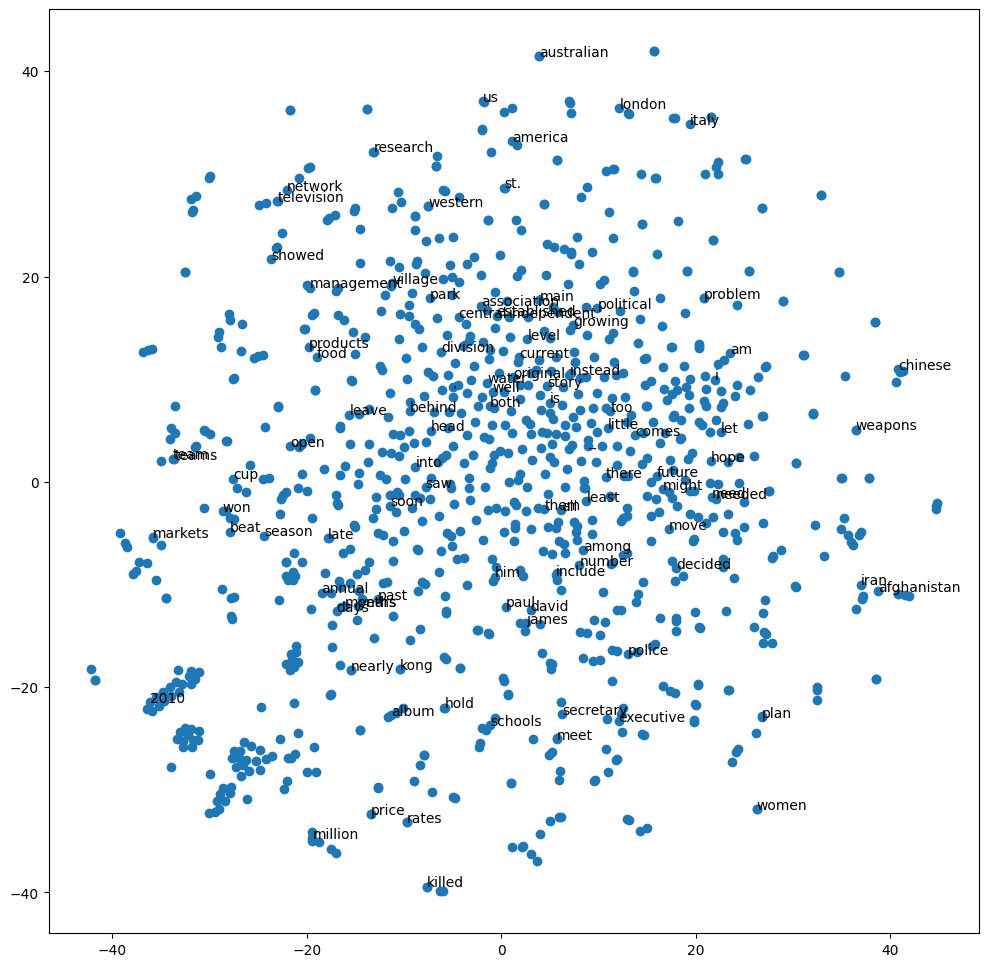

In [17]:
import matplotlib.pyplot as plt
import random

def reduce_dimensions(wv, n):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(wv.vectors[:n])
    labels = np.asarray(wv.index_to_key[:n]) 

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, learning_rate='auto', init='random')
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_matplotlib(x_vals, y_vals, labels):
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    # Label randomly subsampled 100 data points
    random.seed(0)
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 100)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

x_vals, y_vals, labels = reduce_dimensions(wv, 1000)
plot_with_matplotlib(x_vals, y_vals, labels)

[Q7] Implémenter la visualisation grâce à la méthode [MDS](https://andrewirwin.github.io/data-visualization/mds.html), puis avec la méthode [PCA](https://andrewirwin.github.io/data-visualization/pca.html). Quelles sont vos remarques entre les trois visualisations?

Les points sont plus concentrés vers le centre, et le schéma à l'air inversé.


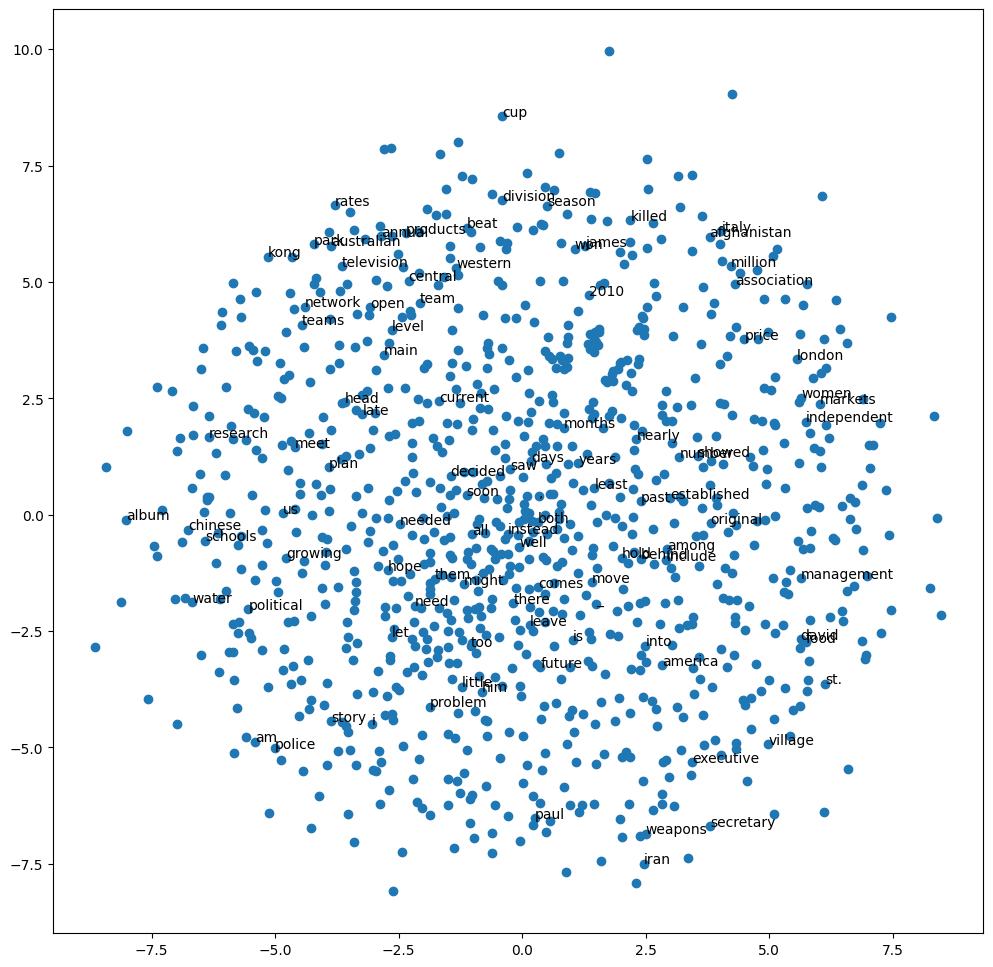

In [18]:
from sklearn.manifold import MDS

def reduce_dimensionsMDS(wv, n):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(wv.vectors[:n])
    labels = np.asarray(wv.index_to_key[:n]) 

    # reduce using t-SNE
    mds = MDS(n_components=num_dimensions, normalized_stress='auto')
    vectors = mds.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x_vals, y_vals, labels = reduce_dimensionsMDS(wv, 1000)
plot_with_matplotlib(x_vals, y_vals, labels)

print("Les points sont plus concentrés vers le centre, et le schéma à l'air inversé.")

Le schéma n'a pas la même forme que les autre, et c'est encore plus concentré vers le centre.


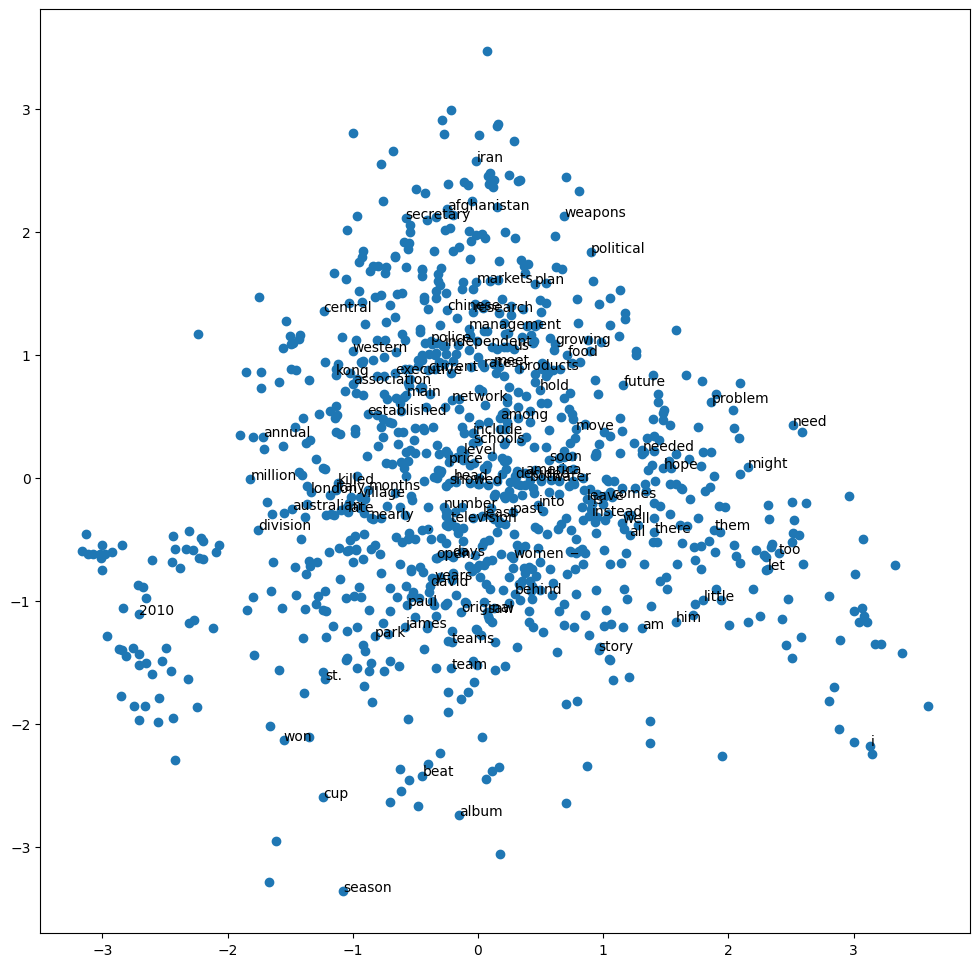

In [19]:
def reduce_dimensionsPCA(wv, n):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(wv.vectors[:n])
    labels = np.asarray(wv.index_to_key[:n]) 

    # reduce using t-SNE
    pca = PCA(n_components=num_dimensions)
    vectors = pca.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x_vals, y_vals, labels = reduce_dimensionsPCA(wv, 1000)
plot_with_matplotlib(x_vals, y_vals, labels)

print("Le schéma n'a pas la même forme que les autre, et c'est encore plus concentré vers le centre.")

4 - PROJET : Réécrire un texte à partir de tranformations basées sur les plongements lexicaux 
------

[Projet Q1] Réécrire un texte donné en anglais de sorte à ce que chaque substantif du texte soit remplacé par le Kème mot le plus proche dans le plongement lexical. Vous générerez le nuage de mots correspondant à partir du texte réécrit.

In [42]:
#!pip install --upgrade spacy
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 573.4 kB/s eta 0:00:23
      --------------------------------------- 0.2/12.8 MB 1.4 MB/s eta 0:00:10
      --------------------------------------- 0.3/12.8 MB 1.6 MB/s eta 0:00:08
     - -------------------------------------- 0.4/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.6/12.8 MB 1.9 MB/s eta 0:00:07
     -- ------------------------------------- 0.7/12.8 MB 2.0 MB/s eta 0:00:06
     -- ------------------------------------- 0.9/12.8 MB 2.2 MB/s eta 0:00:06
     --- ------------------------------------ 1.2/12.8 MB 2.7 MB/s eta 0:00:05
     ---- ----------------------------------- 1.4/12.8 MB 2.8 MB/s eta 0:00:05
     ---- ----------------------------------- 1.5/12.8 M

In [44]:
from wordcloud import WordCloud
from collections import Counter
import spacy
import os

nlp = spacy.load("en_core_web_sm")

wv = api.load('glove-wiki-gigaword-300')
#wv = api.load('conceptnet-numberbatch-17-06-300')

[The, US, Men, ’s, National, Team, (, USMNT, ), was, made, to, work, hard, for, its, place, in, the, World, Cup, knockout, stage, ,, earning, a, tough, 1, -, 0, win, over, Iran, in, a, nerve, -, racking, Group, B, decider, at, Qatar, 2022, ., Christian, Pulisic, ’s, first, -, half, goal, was, all, that, separated, the, two, sides, as, the, USMNT, reached, the, round, of, 16, for, the, first, time, since, 2014, ., The, pressure, was, certainly, on, for, Gregg, Berhalter, ’s, side, in, Qatar, after, the, national, team, ’s, failure, to, qualify, for, the, 2018, World, Cup, ,, but, the, US, got, the, job, done, with, three, gritty, group, performances, .]
['The', 'US', 'Men', '’s', 'National', 'Team', '(', 'USMNT', ')', 'was', 'made', 'to', 'work', 'hard', 'for', 'its', 'time', 'in', 'the', 'World', 'Cup', 'knockouts', 'theater', ',', 'earning', 'a', 'tough', '1', '-', '0', 'winning', 'over', 'Iran', 'in', 'a', 'sarin', '-', 'racking', 'Group', 'B', 'kilkenny', 'at', 'Qatar', '2022', '.',

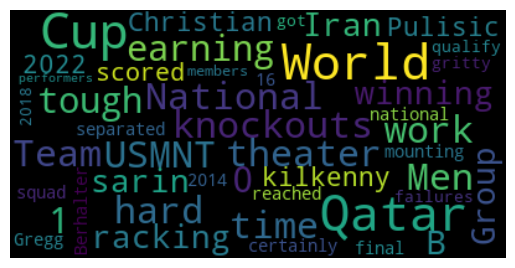

In [112]:
# fonction permettant de generer un nuage de mots à partir d'une liste de mots et de leur fréquence.
def generate_wordcloud(freq_list):
    wordcloud = WordCloud(max_font_size=40).generate_from_frequencies(freq_list)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

# retourne la fréquence des 50 mots les plus fréquents d'un document.
def frequency50(doc): # doc = nlp(text)
    freq_list = Counter(token.text for token in doc if not token.is_stop and not token.is_punct  if not "\n" in token.text)
    list = freq_list.most_common(50)
    return list

# retourne la fréquence de tous les mots d'un document.
def frequency(doc): # doc = nlp(text)
    freq_list = Counter(token.text for token in doc if not token.is_stop and not token.is_punct  if not "\n" in token.text)
    return freq_list

# fonction qui va trouver le kème mot le plus proche d'un mot et va le retourner
def keme_voisin_proche(word, k):
    list = []
    try :
        list = wv.most_similar(positive=[word], topn=k)
    except :
        #print("Le mot n'est pas dans la liste")
        return None
    keme_mot = list[k-1][0]
    return keme_mot
    

# fonction qui à partir d'un fichier, le transforme en objet nlp (spaCy)
def ouverture_lecture_texte(path):
    text = ""
    with open(path, encoding='utf-8') as f:
        text = f.read()
    doc = nlp(text)
    return doc

text_path1 = "sport-en.txt"
text_path2 = "gender-en.txt"
text_path3 = "sport-en-original.txt"

# ouverture des fichiers
doc1 = ouverture_lecture_texte(text_path1)
#doc2 = ouverture_lecture_texte(text_path2)
#doc3 = ouverture_lecture_texte(text_path3)

list_text = []
list_text_copy = []

for i in range (len(doc1)):
    list_text.append(doc1[i])

for i in range(len(list_text)):
    #list_texte[i] est un adjectif ou un substantif
    if list_text[i].pos_ == "NOUN":
        try :
            word = keme_voisin_proche(list_text[i].text, 2)
            list_text_copy.append(word)
        except :
            list_text_copy.append(list_text[i].text)
    else :
        list_text_copy.append(list_text[i].text)


print(list_text)
print(list_text_copy)
list = []
for i in range(len(list_text_copy)):
    if list_text_copy[i] == None:
        list.append(i)

list_text_copy.pop(list[0])

text_new = " ".join(list_text_copy)

print(doc1)
print(text_new)

tt = nlp(text_new)

freq = frequency(tt)

generate_wordcloud(freq)

[Projet Q2] Réécrire un texte donné en anglais en le genrifiant. Ainsi, chaque substantif et adjectif du texte devra être remplacé par le premier mot le plus proche dans le plongement lexical suivant la direction de genrification féminine. Il suffira alors d'utiliser les opérations d'analogie. Vous générerez le nuage de mots correspondant à partir du texte réécrit.

The US Men’s National Team (USMNT) was made to work hard for its place in the World Cup knockout stage, earning a tough 1-0 win over Iran in a nerve-racking Group B decider at Qatar 2022.

Christian Pulisic’s first-half goal was all that separated the two sides as the USMNT reached the round of 16 for the first time since 2014.

The pressure was certainly on for Gregg Berhalter’s side in Qatar after the national team’s failure to qualify for the 2018 World Cup, but the US got the job done with three gritty group performances.


The US Men ’s National Team ( USMNT ) was made to work hard for its nice in the World Cup knock-out touches , earning a tricky 1 - 0 triumph over Iran in a endings - racking Group B all-ireland at Qatar 2022 . 

 Christian Pulisic ’s third - minute scored was all that separated the two stressing as the USMNT reached the quarterfinals of 16 for the third so since 2014 . 

 The exerted was certainly on for Gregg Berhalter ’s touches in Qatar after the acronym cham

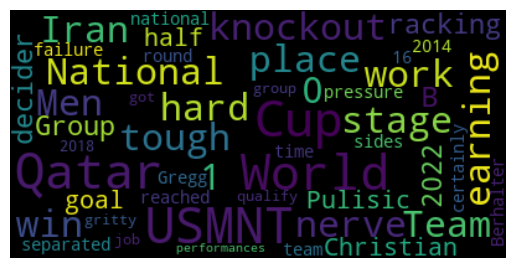

In [91]:
texte = ouverture_lecture_texte(text_path1)
list_texte = []
list_texte_copy = []

for i in range (len(texte)):
    list_texte.append(texte[i])

for i in range(len(list_texte)):
    #list_texte[i] est un adjectif ou un substantif
    if list_texte[i].pos_ == "ADJ" or list_texte[i].pos_ == "NOUN":
        try :
            word = wv.most_similar(positive=['feminine', list_texte[i].text], negative=['male'])[1]
            list_texte_copy.append(word[0])
        except :
            list_texte_copy.append(list_texte[i].text)
    else :
        list_texte_copy.append(list_texte[i].text)


texte_new = " ".join(list_texte_copy)

print(texte)
print(texte_new)

t1 = nlp(texte)
t2 = nlp(texte_new)

freq1 = frequency(t1)
freq2 = frequency(t2)
print(freq)

generate_wordcloud(freq1)


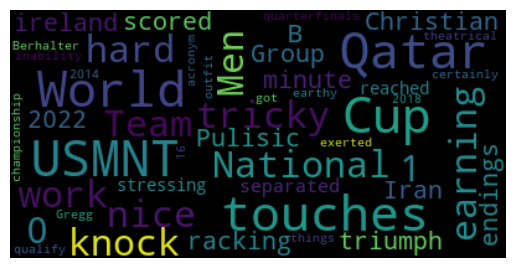

In [92]:
generate_wordcloud(freq2)

5 - PROJET : Redéfinir l'algorithme Lesk
------

[Projet Q3] L'algorithme de Lesk (https://en.wikipedia.org/wiki/Lesk_algorithm) permet de désambiguiser le sens d'un mot dans un contexte défini. Ainsi il retourne le sens correspondant à un mot dans un contexte donné. La fonction OVERLAP implémentée dans l'algorithme Lesk permet de choisir le meilleur sens en fonction du cardinal de l'intersection des mots entre la définition du sens et le contexte textuel. 

Ici, vous proposerez de faire cette sélection à partir d'une représentation sémantique continue des phrases. Chaque phrase devra être donc représentée par un vecteur sémantique. Vous pourrez utiliser le vecteur moyen de tous les mots dans une phrase (average pooling) ou des techniques plus abouties comme celle proposé par [(Hovy, 2025)](https://aclanthology.org/P15-1073.pdf). Le sens d'un mot dans son contexte sera donc celui qui maximise la similarité entre la représentation sémantique de la définition et celle du contexte.

In [24]:
# insérer votre code ici

In [25]:
# insérer votre code ici

6 - PROJET MAISON  (A RENDRE UNE SEMAINE AVANT L'EXAMEN TERMINAL)
------

Vous devrez proposer une méthode originale de réécriture créative de texte dans la veine d\'OULIPO qui combine à la fois la ressource lexicale wordnet et les plongements lexicaux. Vous pourrez vous inspirer des nombreuses propostions [OULIPO](https://www.oulipo.net/). Vous pourrez bien entendu inclure tous les concepts abordés pendant les cours théoriques, comme par exemple les entités nommées et les unités polylexicales. Une mention spéciale vous sera accordée si vous travailer sur le Français ou toute autre langue que l'anglais. Dans ce cas, vous aurez besopin d'un moteur de traduction pour accéder aux définitions de wordnet. Vous trouverez des traducteurs [ICI](https://pypi.org/project/translators/). Pour les plongements lexicaux, vous aurez accès aux plongements multilingues de Fasttext [ICI](https://fasttext.cc/docs/en/crawl-vectors.html). 

Bon courage et bonne créativité ;)

In [26]:
# insérer votre code ici